# An Analysis of the 2024 NHL Draft Class: Classical Statistics and Machine Learning Approaches

In [54]:
from scipy.stats import norm
import math
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

In [9]:
draft_data = pd.read_csv("2024 Sound of Hockey Big Board.csv")
draft_goalies = draft_data[draft_data["Position"] == "G"].drop(["Games Played", "Goals", "Assists", "Points", "Points Per Game", "Penalty Minutes", "Plus-minus"], axis = 1)
draft_data = draft_data[draft_data["Position"] != "G"].drop(["Goals Against Average", "Save Percentage", "Wins", "Losses", "Ties", "Shootouts", "Saves", "Goals Against"], axis = 1)

draft_data["Penalty Minutes"] = draft_data["Penalty Minutes"].fillna(draft_data["Penalty Minutes"].median())
draft_data["Plus-minus"] = draft_data["Plus-minus"].fillna(draft_data["Plus-minus"].median())

missing_locations = draft_data[draft_data.isna().any(axis=1)]

print("DataFrame showing rows with missing values:")
print(missing_locations)

DataFrame showing rows with missing values:
Empty DataFrame
Columns: [Composite Rank, Name, Position, Team (23-24), League (23-24), Birthdate, Age, Height (in), Weight (lbs), Games Played, Goals, Assists, Points, Points Per Game, Penalty Minutes, Plus-minus, Draft Round, Draft Pick]
Index: []


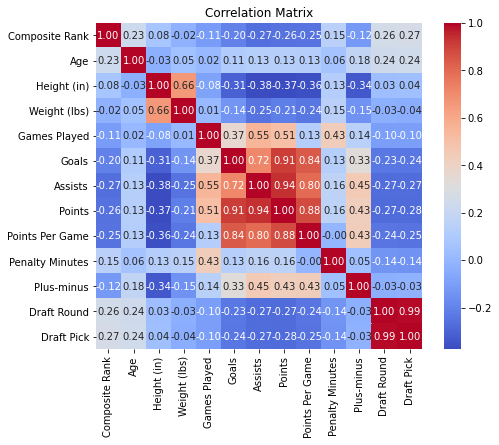

In [49]:
corr_matrix = draft_data.corr()
plt.figure(figsize=(8, 6))
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

# Set plot title
plt.title("Correlation Matrix")
plt.show()

In [4]:
print(draft_data.describe())

       Composite Rank         Age  Height (in)  Weight (lbs)  Games Played  \
count      201.000000  201.000000   201.000000    201.000000    201.000000   
mean       411.601990   18.049751    73.557214    187.074627     50.965174   
std       1072.472396    0.712399     2.178981     14.655013     14.636044   
min          1.000000   17.000000    67.000000    143.000000      7.000000   
25%         50.000000   18.000000    72.000000    176.000000     40.000000   
50%        109.000000   18.000000    73.000000    187.000000     54.000000   
75%        204.000000   18.000000    75.000000    196.000000     64.000000   
max       6582.000000   20.000000    79.000000    229.000000     68.000000   

            Goals     Assists      Points  Points Per Game  Penalty Minutes  \
count  201.000000  201.000000  201.000000       201.000000       200.000000   
mean    16.417910   25.268657   41.686567         0.799652        37.615000   
std     13.291895   15.790423   26.947472         0.468685  

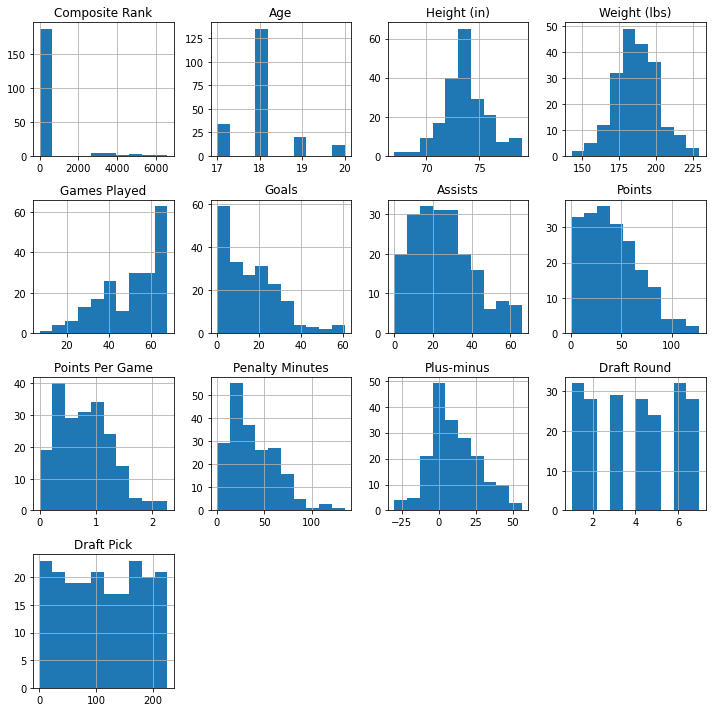

In [5]:
draft_data.hist(bins=10, figsize=(10, 10))
plt.tight_layout()
plt.show()

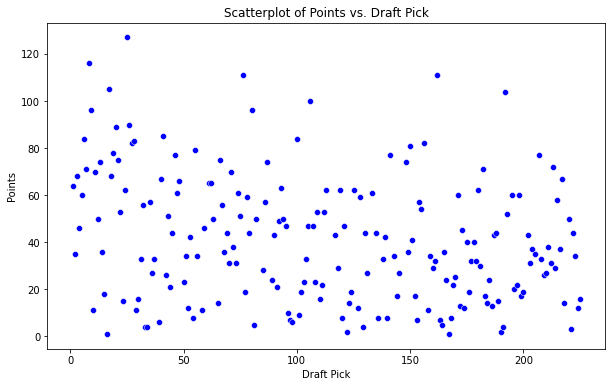

In [60]:
# Create a scatterplot using Seaborn
plt.figure(figsize=(10, 6))
sn.scatterplot(x='Draft Pick', y='Points', data=draft_data, marker='o', color='blue')

# Set plot title and labels
plt.title('Scatterplot of Points vs. Draft Pick')
plt.xlabel('Draft Pick')
plt.ylabel('Points')

# Show the plot
plt.show()

In [45]:
X = draft_data[["Composite Rank", "Height (in)", "Weight (lbs)", "Goals", "Assists", "Points", "Points Per Game", "Penalty Minutes", "Plus-minus"]]
y = draft_data["Draft Pick"]
y = list(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_preprocessed = pd.DataFrame(X_scaled, columns=X.columns)


# Add an intercept
X_preprocessed = sm.add_constant(X_preprocessed)

model = sm.OLS(y, X_preprocessed).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     4.493
Date:                Sat, 17 Aug 2024   Prob (F-statistic):           5.11e-05
Time:                        13:58:57   Log-Likelihood:                -1111.5
No. Observations:                 201   AIC:                             2241.
Df Residuals:                     192   BIC:                             2271.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             112.0249      4.401     

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = X.columns


models = {
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Neural Network': MLPRegressor(max_iter=4000, random_state=42),  # Neural Network model
    'Elastic Net': ElasticNet(),
    'Bayesian Ridge': BayesianRidge(),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}


results = {}
importances = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'Mean Squared Error': mse,
        'R-squared': r2
    }
    
    if hasattr(model, 'coef_'):
        # Linear models and Lasso/Ridge/ElasticNet
        importances[name] = model.coef_
    elif hasattr(model, 'feature_importances_'):
        # Tree-based models
        importances[name] = model.feature_importances_
    else:
        importances[name] = None

results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='R-squared', ascending=False))

print("\nFeature Importances or Coefficients:")

for name, importance in importances.items():
    if importance is not None:
        print(f"\n{name}:")
        if len(importance) == len(feature_names):
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importance
            }).sort_values(by='Importance', ascending=False)
            print(importance_df)
        else:
            print("Feature importance data not available.")
    else:
        print(f"{name} does not provide feature importances or coefficients.")

                           Mean Squared Error  R-squared
K-Nearest Neighbors               1313.502439   0.621264
Random Forest                     1514.149344   0.563409
Gradient Boosting                 1770.216781   0.489575
Neural Network                    2975.018575   0.142182
Decision Tree                     3165.414634   0.087283
Support Vector Regression         3378.948519   0.025712
Bayesian Ridge                    3438.086147   0.008660
Elastic Net                       3836.571806  -0.106239
Lasso Regression                  3910.887622  -0.127667
Ridge Regression                  4013.458438  -0.157243

Feature Importances or Coefficients:

Ridge Regression:
           Feature  Importance
1      Height (in)    5.221956
8       Plus-minus    0.357526
3            Goals    0.276768
0   Composite Rank    0.012841
5           Points   -0.103059
4          Assists   -0.379827
7  Penalty Minutes   -0.503413
2     Weight (lbs)   -1.015558
6  Points Per Game  -28.394943

Lasso